In [ ]:
# Post for this notebook at https://ak10net.github.io/2021-05-01/content-recommender

In [131]:
from collections import Counter
import pandas as pd
import re
from langdetect import detect
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from collections import Counter
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.figsize':(10,7)})
pd.set_option('max_colwidth', 400)

In [132]:
# Data source - https://www.cs.cornell.edu/~arb/data/genius-expertise/
# About the dataset - https://github.com/cptq/genius-expertise/tree/master/data
df = pd.read_json('lyrics.jl', lines=True)

In [137]:
df.sample(5)

,song,lyrics
33860,Vice-obsession-lyrics,"\n\n[Verse 1: Jon Bellion]\nIt's 2AM and cold outside\nIs it too late to come, oh?\nI can't even sleep at night 'cause, oh\nIt's 3AM, I'm parked outside\nI'm walking to your door, oh\nAnd that can't wait another night 'cause, oh\n\n[Chorus: Jon Bellion]\nOh, twenty-five, twenty-five seven and\nI give you all my attention\nBaby, you're my obsession\nOh, twenty-five, twenty-five seven and\nI giv..."
5278,Lil-wayne-no-lie-remix-lyrics,"\n\n[Intro]\nEar Drummers\nMike WiLL Made-It\n\n[Verse 1]\nI am sippin' on that lean, don't bring me no bottles, ho\nI make it rain so hard, flowers grow, Hollygrove\nFour baby mamas, no baby mama drama\nBad bitch at home sleep, I go home and sleep behind her, uh\nShout out to my weed man, shout out to my lean man\nI'm sittin' on these motherfuckin' millions like a beanbag\nFuck you, don't jud..."
6908,Jay-z-devils-lyrics,"\n\n[Produced by DJ Premier]\n\n[Hook Samples: Snoop Dogg + Prodigy]\n""Dear God – I wonder, can you save me?""\n""Illuminati want my mind, soul and my body""\n""Dear God – I wonder, can you save me?""\n""Secret society, tryna keep they eye on me""\n""Dear God – I wonder, can you save me?""\n""Illuminati want my mind, soul and my body""\n""Dear God – I wonder, can you save me?""\n""I can't die, I can't die, ..."
16394,Lecrae-darkest-hour-lyrics,"\n\n[Intro: No Malice]\nOk, yes, uh huh, No Malice and Lecrae\n\n[Verse 1: No Malice]\nLord have mercy and pity on your son\nFrom what I once was, to what I have become\nForgive me for my past and the noses left numb\nAs I'm led down this path to the beat of a different drum\nFee-fi-fo-fum I'm conquering my giants\nAnd all by my lonesome I'm conquering Goliath\nI cut it on the buyers, now I tr..."
17398,Nirvana-all-apologies-lyrics,"\n\n[Verse 1]\nWhat else should I be? All apologies\nWhat else could I say? Everyone is gay\nWhat else should I write? I don't have the right\nWhat else should I be? All apologies\n\n[Chorus]\nIn the sun, in the sun, I feel as one\nIn the sun, in the sun\nMarried, buried\n\n[Verse 2]\nI wish I was like you, easily amused\nFind my nest of salt, everything is my fault\nI'll take all the blame, I..."


In [121]:
def lang_detector(x):
    '''
        takes a string and returns language of string
    '''
    try:
        return detect(x)
    except:
        return 'unknown language'

def cleaner(df):
    '''
        cleans song column
        extract artist from song column
        cleans lyrics column
        applies lang_detector function 
        creates new column for song length
        removes songs of laguage other than english
        removes outliers calculated using song length
        creates new column of song_length_quantiles for viz
        returns cleand df
    '''
    df['artist'] = df['song'].apply(lambda x: ' '.join(x.split('-')[:2]))
    df['song'] = df['song'].apply(lambda x: x[:-7])    
    df['lyrics'] = df['lyrics'].apply(lambda x: re.sub("[\(\[].*?[\)\]]", "", x))
    df['lyrics'] = df['lyrics'].apply(lambda x: re.sub('\n\n', '', x))
    df['lyrics'] = df['lyrics'].apply(lambda x: re.sub('\n', ' ', x))
    df['lang'] = df['lyrics'].apply(lambda x: lang_detector(x))
    df = df[df['lang'] == 'en']
    df['song_length'] = df['lyrics'].apply(lambda x: len(x))
    Q1 = df['song_length'].quantile(0.25)
    Q3 = df['song_length'].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df['song_length'] > (Q1 - 1.5 * IQR)) & (df['song_length'] < (Q3 + 1.5 * IQR))]
    df['song_length_quantiles'] = pd.cut(df['song_length'], bins=10, precision=0)    
    return df

In [122]:
df = cleaner(df)

c:\users\ankit.dubey\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


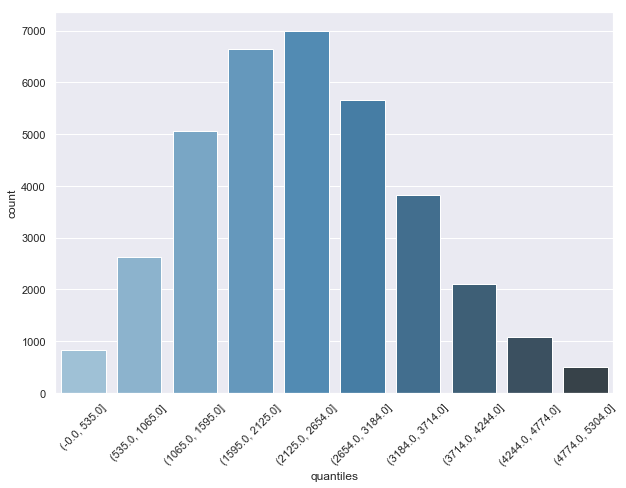

In [123]:
song_len_df = df['song_length_quantiles'].value_counts(sort=True).reset_index().rename(columns={'index': 'quantiles', 'song_length_quantiles':'count'})
sns.barplot(x='quantiles', y='count', data=song_len_df,   palette="Blues_d")
plt.xticks(rotation=45)
plt.show()

In [124]:
df = df.drop_duplicates(subset='artist', keep='first')
df = df.reset_index(level=0)
df['id'] = df['index']
df = df.drop(['index'], axis=1)

In [125]:
# Calculating cosine similarities from lyrics and storing similar song results in results dict
tf = TfidfVectorizer(analyzer='word', min_df=0, max_features= 100 ,stop_words='english', lowercase=True)
tfidf_matrix = tf.fit_transform(df['lyrics'])

cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)
results = {}

for idx, row in df.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-100:-1]
    similar_items = [(cosine_similarities[idx][i], df['id'][i]) for i in similar_indices]
    results[row['id']] = similar_items[1:]

In [128]:
def item(id):
    return df.loc[df['id'] == id]['song']

def recommend(id, num):
    print("Recommending " + str(num) + " songs similar to " + item(id))
    recs = results[id][:num]
    i=0
    for rec in recs:
        print("We recommend : " + item(rec[1]) + " (score:" + str(rec[0]) + ")")

In [129]:
recommend(14,3)

2    Recommending 3 songs similar to Travis-scott-goosebumps
Name: song, dtype: object
6954    We recommend : Tyga-u-cry (score:0.9022309682343544)
Name: song, dtype: object
1819    We recommend : Goldlink-u-say (score:0.8874335491812315)
Name: song, dtype: object
1662    We recommend : Logic-time-machine (score:0.8612878563854101)
Name: song, dtype: object


### EDA below

In [ ]:
print(f'Dataset has total {df.shape[0]} songs from {df.artist.nunique()}')

In [66]:
df[df['id']==14]['lyrics']

2     Yeah 7:30 in the night, yeah Ooh-oooh, ooh I get those goosebumps every time, yeah, you come around, yeah You ease my mind, you make everything feel fine Worried 'bout those comments I'm way too numb, yeah, it's way too dumb, yeah I get those goosebumps every time, I need the Heimlich Throw that to the side, yeah I get those goosebumps every time, yeah When you're not around  When you throw t...
Name: lyrics, dtype: object

In [67]:
df[df['id']==6954]['lyrics']

2187     Talk that talk to me, yeah Talk that talk to me, yeah I be tryna chill, bitches wanna fuck me Every little city I go, "Fuck me!" Shawty must’ve heard, got the word, I move that D Had it by her bladder, she like, “Oh, I gotta pee!” Hahaha Ran into a Rothko in my restroom Singer slash actress in my bedroom Gotta have a ticket for a walk through Everything I do is Big  I talk big money, I talk b...
Name: lyrics, dtype: object

In [12]:
df[df['song_length'] == df['song_length'].min()]

,song,lyrics,lang,song_length
37058,Pink-guy-club-banger-3000,Hey,en,5


In [13]:
df[df['song_length'] == df['song_length'].max()]

,song,lyrics,lang,song_length
29861,Barack-obama-third-presidential-debate-of-2012-an,"SCHIEFFER: Good evening from the campus of Lynn University here in Boca Raton, Florida. This is the fourth and last debate of the 2012 campaign, brought to you by the Commission on Presidential Debates. This one's on foreign policy. I'm Bob Schieffer of CBS News. The questions are mine, and I have not shared them with the candidates or their aides. The audience has taken a vow of silence - no ...",en,94758
